# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_year_date_str_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260109.xlsx"
code = "8306"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_year_date_str_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/0109
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 60
PERIOD_MA_2 : 600
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 5.0
LOSSCUT_1 : -25


In [3]:
# 取引明細
df_transaction = app.getTransaction()
print("取引明細")
list_html = conv_transaction_df2html(df_transaction)
filename = os.path.join("output", f"{date_str}_{code}_transaction.html")
print(filename)
with open(filename, mode="w") as f:
    f.write("\n".join(list_html))

print(df_transaction)
list_trans = [pd.to_datetime(t) for t in df_transaction["注文日時"]]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
output/2026/0109_8306_transaction.html
  注文番号                 注文日時 銘柄コード  売買    約定単価 約定数量      損益 備考
0    1  2026-01-09 09:10:10  8306  売建  2621.0  100     NaN   
1    2  2026-01-09 09:11:40  8306  買埋  2625.5  100  -450.0   
2    3  2026-01-09 09:11:41  8306  買建  2625.5  100     NaN   
3    4  2026-01-09 09:48:50  8306  売埋  2658.5  100  3300.0   
4    5  2026-01-09 10:00:28  8306  買建  2662.5  100     NaN   
5    6  2026-01-09 10:16:54  8306  売埋  2669.0  100   650.0   
6    7  2026-01-09 10:16:55  8306  売建  2669.0  100     NaN   
7    8  2026-01-09 10:19:54  8306  買埋  2673.5  100  -450.0   
8    9  2026-01-09 15:06:23  8306  売建  2645.5  100     NaN   
9   10  2026-01-09 15:15:01  8306  買埋  2647.5  100  -200.0   
取引回数: 10 回 / 総収益: 2850.0 円/株


In [4]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts   price          ma1          ma2    slope1  \
2026-01-09 09:00:04  1.767917e+09  2621.0  2621.000000  2621.000000  0.000000   
2026-01-09 09:00:05  1.767917e+09  2621.0  2621.000000  2621.000000  0.000000   
2026-01-09 09:00:06  1.767917e+09  2625.0  2622.333333  2622.333333  0.800000   
2026-01-09 09:00:07  1.767917e+09  2625.0  2623.000000  2623.000000  0.761905   
2026-01-09 09:00:08  1.767917e+09  2623.5  2623.100000  2623.100000  0.544444   
...                           ...     ...          ...          ...       ...   
2026-01-09 15:24:45  1.767940e+09  2647.0  2647.400000  2646.411667  0.003056   
2026-01-09 15:24:46  1.767940e+09  2647.5  2647.408333  2646.411667  0.003889   
2026-01-09 15:24:47  1.767940e+09  2647.5  2647.416667  2646.411667  0.005278   
2026-01-09 15:24:48  1.767940e+09  2647.5  2647.425000  2646.411667  0.007222   
2026-01-09 15:24:49  1.767940e+09  2647.5  2647.433333  2646.411667  0.008333   

                   

In [5]:
df_tech["slope1"].describe()

count    19425.000000
mean         0.019778
std          0.022693
min          0.000000
25%          0.006111
50%          0.013611
75%          0.025000
max          0.800000
Name: slope1, dtype: float64

In [6]:
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

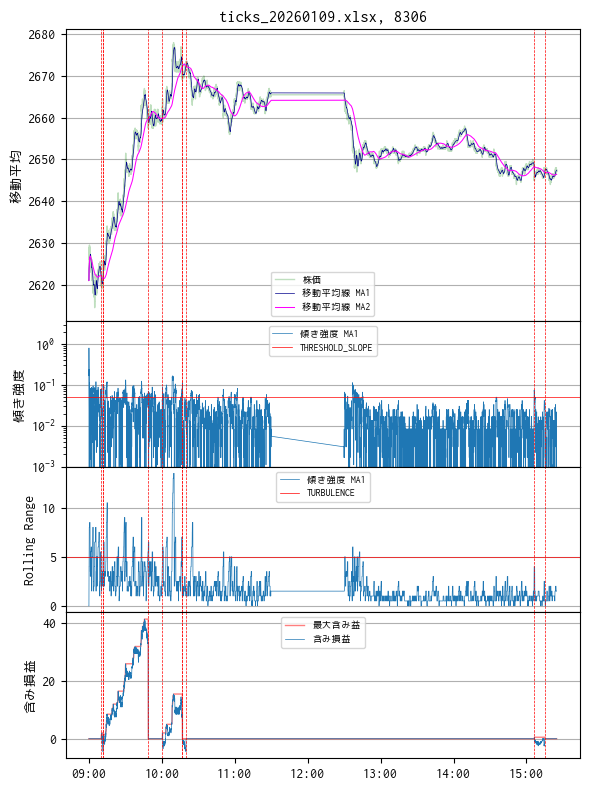

In [7]:
fig = plt.figure(figsize=(6, 8))
n = 4
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)
_, y_high = ax[1].get_ylim()
ax[1].set_ylim(0.001, y_high)

ax[2].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[2].set_ylabel("Rolling Range")
ax[2].legend(fontsize=7)

ax[3].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[3].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[3].set_ylabel("含み損益")
ax[3].legend(fontsize=7)

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
# output = os.path.join("output", f"{date_str}_{code}_trend_technical.png")
output = os.path.join("tmp", f"{date_str}_{code}_trend_technical.png")
plt.tight_layout()
plt.savefig(output)
plt.show()

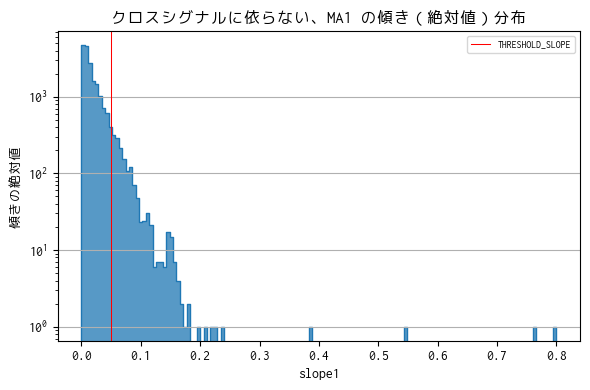

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("クロスシグナルに依らない、MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
# output = os.path.join("output", f"{date_str}_{code}_trend_technical.png")
output = os.path.join("tmp", f"{date_str}_{code}_hist_slope.png")
plt.savefig(output)
plt.show()

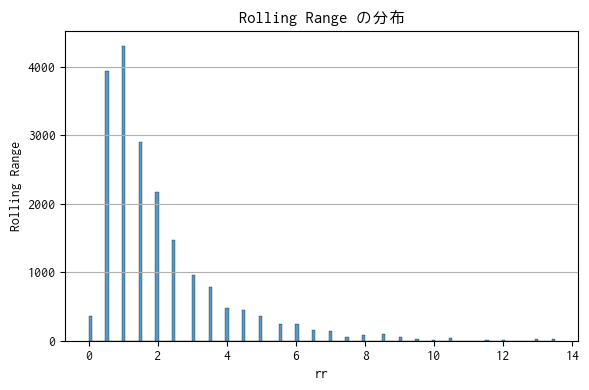

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
# output = os.path.join("output", f"{date_str}_{code}_trend_technical.png")
output = os.path.join("tmp", f"{date_str}_{code}_hist_rr.png")
plt.savefig(output)
plt.show()

In [10]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1   建玉
2026-01-09 09:00:04    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 09:00:05    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 09:00:06    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 09:00:07    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 09:00:08    0.0    0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...
2026-01-09 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0

[19425 rows x 6 columns]


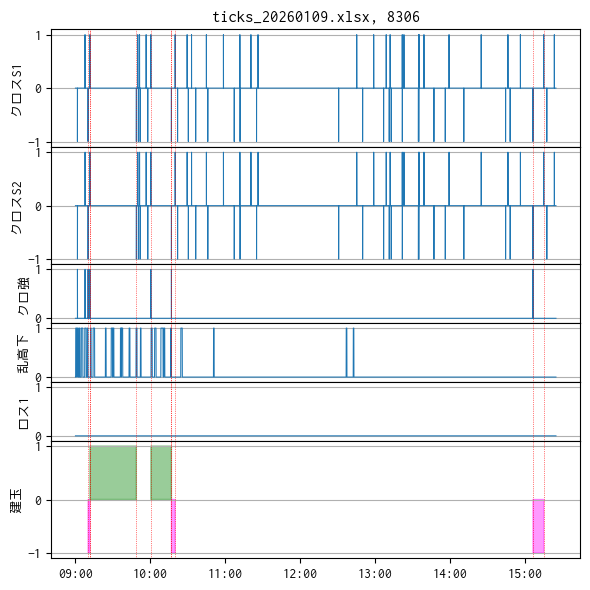

In [11]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True)
        ax_i.fill_between(x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True)
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
# output = os.path.join("output", f"{date_str}_{code}_trend_obs.png")
output = os.path.join("tmp", f"{date_str}_{code}_trend_obs.png")
plt.tight_layout()
plt.savefig(output)
plt.show()